In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# import pickle as pk
import pytz
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from os import path
import sys
from mmctools.plotting import TaylorDiagram
from scipy.stats import pearsonr
import glob
from mmctools.wrf.utils import tsout_seriesReader
from matplotlib.colors import Normalize
from string import ascii_lowercase
from matplotlib.legend_handler import HandlerBase

In [3]:
main_directory = '/glade/scratch/hawbecke/WRF/MMC/NYSERDA/SENSITIVITY_SUITE/'
#main_directory = '/glade/work/hawbecke/MMC/NYSERDA/WRF/SENSITIVITY_SUITE/'

icbc_type = 'MERRA2'  # ERAI, ERA5, FNL

from NYSERDA_case_dict import case_dict

cases = [case_dict[x]['case_str'] for x in list(case_dict.keys())]

eta_level_testing = False
if eta_level_testing:
    main_directory += 'eta_level_test/'
    cases = cases[-3:]
    time_step = 5.0
else:
    cases = cases[:]
    failed_cases = []
    for case in failed_cases:
        cases.remove(case)
    time_step = 6.0

sim_start = '2020-04-04 06:00:00'
#case_start = '2020-04-05 16:00:00'
#case_end   = '2020-04-06 06:00:00'
case_start = '2020-04-06 02:00:00'
case_end   = '2020-04-06 03:00:00'

best_case  = 'WPS3_WRF1'
n_profiles = 8

dom_dict = {1: {'dt':15,
                'marker': r'$ 1 $',
                'ls':'-'},
            2: {'dt':5,
                'marker': r'$ 2 $',
                'ls':'--'},
            3: {'dt':1,
                'marker': r'$ 3 $',
                'ls':'-'},
            4: {'dt':0.2,
                'marker': r'$ 4 $',
                'ls':'-.'},
            5: {'dt':0.04,
                'marker': r'$ 5 $',
                'ls':':'},
            }
doms_of_interest = [1,2,4,5]

#for cc,case in enumerate(cases):
#    plt.plot(np.arange(0,10),np.arange(0,10)*cc,c=case_dict[case]['color'])

# Get Obs:

In [4]:
obs_dir = '/glade/work/hawbecke/MMC/NYSERDA/obs/'
obs_res = 'low' # 'low' or 'high'

if obs_res == 'low':
    nyserda_full = xr.open_dataset('{}NYSERDA_lidars.nc'.format(obs_dir))
    atlshrs_full = xr.open_dataset('{}ATLSHORES_lidars.nc'.format(obs_dir))

    nyserda_obs = nyserda_full.sel(case='obs')
    atlshrs_obs = atlshrs_full.sel(case='obs')

    best_case = 'WPS3_WRF1'
    nyserda_opt = nyserda_full.sel(case=best_case)
    atlshrs_opt = atlshrs_full.sel(case=best_case)
else:
    nyserda_obs = xr.open_dataset('{}NYSERDA_lidars_highRes.nc'.format(obs_dir))

# Get WRF for multiple domains:

In [5]:
wrf_data = {}
avg_twr_dict = {}

doms_of_interest = [1,2,4,5]

show_plot = False

twr_directory = '/glade/scratch/hawbecke/WRF/MMC/NYSERDA/SENSITIVITY_SUITE/tower_netCDFs/'

cases_of_interest = ['MERRA2_DFLT_NOSK_CHRN_MDIS','MERRA2_DFLT_NOSK_SHAL_MDIS']
for dd,dom in enumerate(doms_of_interest):
    
    time_step = dom_dict[dom]['dt']
    dom_str = 'd0{}'.format(dom)

    #for cc,case in enumerate(cases):
    for cc,case in enumerate(cases_of_interest):
        if dd == 0:
            wrf_data[case] = {}
            avg_twr_dict[case] = {}
        #tower_f = '{0}{1}/NYSERDA_{1}_towers_{2}.nc'.format(main_directory,case,dom_str)
        tower_f = '{0}NYSERDA_{1}_towers_{2}.nc'.format(twr_directory,case,dom_str)

        print(tower_f)
        sim_start = '2020-04-04 06:00:00'


        if dom >= 4:
            restarts = ['RESTART_A','RESTART_B','RESTART_C']
            f_dir = '{}LES/{}/'.format(main_directory,case)
            get_avg_profile = True
        else:
            restarts = ['']
            f_dir = '{}{}/'.format(main_directory,case)
            get_avg_profile = False


        if path.exists(tower_f):
            wrf_data[case][dom_str] = xr.open_dataset(tower_f)
            got_twr_data = True
        else:
            if get_avg_profile:
                print('No tower data... checking for average profile')
                got_twr_data = False
            else:
                tower_dat = tsout_seriesReader(fdir=f_dir,
                                               restarts=restarts,
                                               simulation_start_time=[sim_start]*len(restarts),
                                               domain_of_interest=dom_str,
                                               time_step=time_step,
                                               structure='unordered',
                                               #select_tower=['T001','T041','T081']
                                              )
                tower_dat.to_netcdf(tower_f)
                wrf_data[case][dom_str] = tower_dat
            
        if get_avg_profile:
            avg_twr_f = tower_f.replace('.nc','_avg.nc') 
            print(avg_twr_f)
            if path.exists(avg_twr_f):
                avg_twr_dict[case][dom_str] = xr.open_dataset(avg_twr_f)
            else:
                avg_twr = wrf_data[case][dom_str].mean(dim='station')

                avg_twr['lon'] = wrf_data[case][dom_str].lon.mean(dim='station')
                avg_twr['lat'] = wrf_data[case][dom_str].lat.mean(dim='station')
                avg_twr['zsurface'] = wrf_data[case][dom_str].zsurface.mean(dim='station')

                avg_twr = avg_twr.assign_coords({'station':'E06',
                                                 'lat':avg_twr.lat,
                                                 'lon':avg_twr.lon,
                                                 'zsurface':avg_twr.zsurface}).expand_dims({'station':1})

                avg_twr_dict[case][dom_str] = avg_twr
                avg_twr.to_netcdf(tower_f.replace('.nc','_avg.nc'))
                
            if (cc == 1) and (dom == 5) and (show_plot):
                fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(16,8))
                for dd,dom in enumerate([4,5]):
                    dom_str_plt = 'd0{}'.format(dom)
                    wrout_dir = '/glade/scratch/hawbecke/WRF/MMC/NYSERDA/SENSITIVITY_SUITE/LES/MERRA2_DFLT_NOSK_SHAL_MDIS/'
                    wrfout_f = '{}wrfout_d0{}_2020-04-06_03:00:00'.format(wrfout_dir,dom)
                    wrfout = xr.open_dataset(wrfout_f).squeeze()
                    wrf_lon = wrfout.XLONG
                    wrf_lat = wrfout.XLAT
                    wrf_var_to_plot = wrfout.U10#.sel(bottom_top=40)

                    #for axi in range(0,2):
                    #    ax[axi,dd].pcolormesh(wrf_lon,wrf_lat,wrf_var_to_plot)
                    ax[dd].pcolormesh(wrf_lon,wrf_lat,wrf_var_to_plot)

                    for ss,stn in enumerate(wrf_data[case][dom_str_plt].station):
                        i = int(wrf_data[case][dom_str_plt].sel(station=stn).i)-1
                        j = int(wrf_data[case][dom_str_plt].sel(station=stn).j)-1
                        lon = wrf_lon.sel(west_east=i,south_north=j)
                        lat = wrf_lat.sel(west_east=i,south_north=j)
                        #for axi in range(0,2):
                        #    ax[axi,dd].scatter(lon,lat,c='r')
                        if ss == 0:
                            stn_lbl = 'WRF Towers'
                        else:
                            stn_lbl = None
                        ax[dd].scatter(lon,lat,c='r',label=stn_lbl)
                    #for axi in range(0,2):
                    #    ax[axi,dd].scatter(avg_twr_dict[dom_str_plt].lon,avg_twr_dict[dom_str_plt].lat,c='k')
                    ax[dd].scatter(avg_twr_dict[dom_str_plt].lon,avg_twr_dict[dom_str_plt].lat,c='k',label='E06')

                    ax[0].legend(frameon=False,fontsize=14,ncol=2,loc=(0.8,1.01))
                    ax[dd].tick_params(labelsize=14)
                    ax[dd].set_aspect('equal')
                    span = 0.017
                    x_s = -73.438
                    y_s = 39.538
                    
                    #ax[1,dd].set_ylim(y_s,y_s+span)
                    #ax[1,dd].set_xlim(x_s,x_s+span)
                    ax[dd].set_xlabel('Longitude',size=16)
                    ax[dd].set_ylabel('Latitude',size=16)
                    ax[dd].set_title(dom_str_plt,size=22)
                    

/glade/scratch/hawbecke/WRF/MMC/NYSERDA/SENSITIVITY_SUITE/tower_netCDFs/NYSERDA_MERRA2_DFLT_NOSK_CHRN_MDIS_towers_d01.nc
/glade/scratch/hawbecke/WRF/MMC/NYSERDA/SENSITIVITY_SUITE/tower_netCDFs/NYSERDA_MERRA2_DFLT_NOSK_SHAL_MDIS_towers_d01.nc
/glade/scratch/hawbecke/WRF/MMC/NYSERDA/SENSITIVITY_SUITE/tower_netCDFs/NYSERDA_MERRA2_DFLT_NOSK_CHRN_MDIS_towers_d02.nc
/glade/scratch/hawbecke/WRF/MMC/NYSERDA/SENSITIVITY_SUITE/tower_netCDFs/NYSERDA_MERRA2_DFLT_NOSK_SHAL_MDIS_towers_d02.nc
/glade/scratch/hawbecke/WRF/MMC/NYSERDA/SENSITIVITY_SUITE/tower_netCDFs/NYSERDA_MERRA2_DFLT_NOSK_CHRN_MDIS_towers_d04.nc
No tower data... checking for average profile
/glade/scratch/hawbecke/WRF/MMC/NYSERDA/SENSITIVITY_SUITE/tower_netCDFs/NYSERDA_MERRA2_DFLT_NOSK_CHRN_MDIS_towers_d04_avg.nc
/glade/scratch/hawbecke/WRF/MMC/NYSERDA/SENSITIVITY_SUITE/tower_netCDFs/NYSERDA_MERRA2_DFLT_NOSK_SHAL_MDIS_towers_d04.nc
/glade/scratch/hawbecke/WRF/MMC/NYSERDA/SENSITIVITY_SUITE/tower_netCDFs/NYSERDA_MERRA2_DFLT_NOSK_SHAL_M

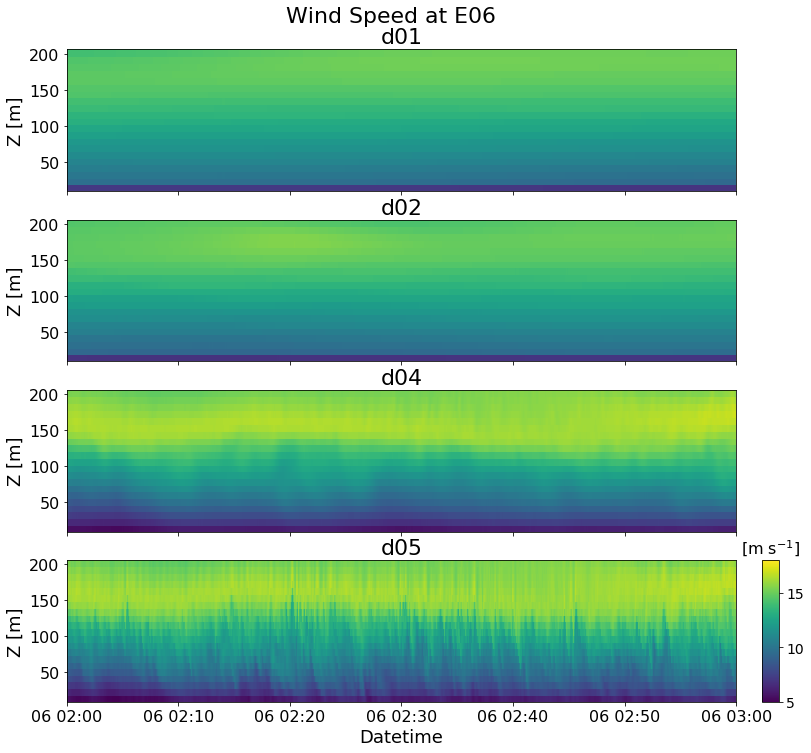

In [6]:
case = cases_of_interest[1]
fig,ax = plt.subplots(nrows=4,figsize=(12,12),sharex=True)
for dd,dom_str in enumerate(list(wrf_data[case].keys())):
    if ('d04' in dom_str) or ('d05' in dom_str):
        twr = wrf_data[case][dom_str].sel(station='T041',nz=slice(0,22),datetime=slice('2020-04-06 02:00:00','2020-04-06 03:00:00'))
    else:
        twr = wrf_data[case][dom_str].sel(station='E06',nz=slice(0,22),datetime=slice('2020-04-06 02:00:00','2020-04-06 03:00:00'))

    z = twr.ph.mean(dim='datetime').data
    t = twr.datetime.data
    
    tz,zt = np.meshgrid(t,z)
    twr_plt = ax[dd].pcolormesh(tz,zt,twr.wspd.T,vmin=5,vmax=18)

    ax[dd].tick_params(labelsize=16)
    ax[dd].set_title(dom_str,size=22)
    ax[dd].set_ylabel('Z [m]',size=18)
ax[3].set_xlabel('Datetime',size=18)

cax  = fig.add_axes([0.93,0.125,0.02,0.164])
cbar = plt.colorbar(twr_plt,cax=cax)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_title('[m s$^{-1}$]',size=16)
plt.suptitle('Wind Speed at E06',size=22,y=0.93)
plt.show()

# Overwrite d04 and d05 data with mean data:

In [7]:
# Overwrite wrf_data with avg_twr_dict for LES domains:
#for key in list(avg_twr_dict.keys()):
#    wrf_data[case][key] = avg_twr_dict[key]
for case in cases_of_interest:
    print(case)
    for key in list(avg_twr_dict[case].keys()):
        wrf_data[case][key] = avg_twr_dict[case][key]

    print(wrf_data[case]['d05'].datetime.data[0],wrf_data[case]['d05'].datetime.data[-1])
    #print(wrf_data[case]['d05'])
    print()

MERRA2_DFLT_NOSK_CHRN_MDIS
2020-04-06T02:00:00.040000000 2020-04-06T02:57:04.000000000

MERRA2_DFLT_NOSK_SHAL_MDIS
2020-04-06T02:00:00.040000000 2020-04-06T03:00:00.000000000



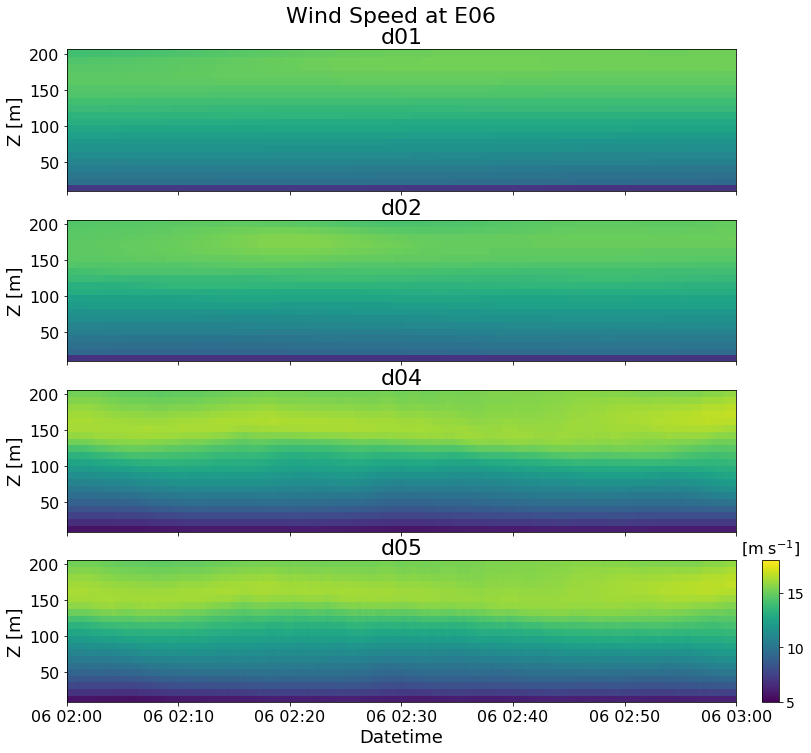

In [8]:
case = cases_of_interest[1]
fig,ax = plt.subplots(nrows=4,figsize=(12,12),sharex=True)
for dd,dom_str in enumerate(list(wrf_data[case].keys())):
    twr = wrf_data[case][dom_str].sel(station='E06',nz=slice(0,22),datetime=slice('2020-04-06 02:00:00','2020-04-06 03:00:00'))

    z = twr.ph.mean(dim='datetime').data
    t = twr.datetime.data
    
    tz,zt = np.meshgrid(t,z)
    twr_plt = ax[dd].pcolormesh(tz,zt,twr.wspd.T,vmin=5,vmax=18)

    ax[dd].tick_params(labelsize=16)
    ax[dd].set_title(dom_str,size=22)
    ax[dd].set_ylabel('Z [m]',size=18)
ax[3].set_xlabel('Datetime',size=18)

cax  = fig.add_axes([0.93,0.125,0.02,0.164])
cbar = plt.colorbar(twr_plt,cax=cax)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_title('[m s$^{-1}$]',size=16)
plt.suptitle('Wind Speed at E06',size=22,y=0.93)

plt.show()

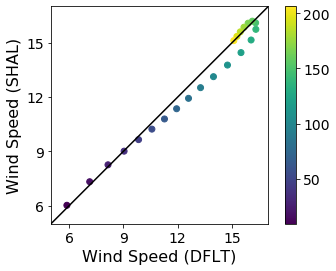

In [9]:
chrn = wrf_data[cases_of_interest[0]]['d05'].wspd.mean(dim='datetime').squeeze().sel(nz=slice(0,22))
shal = wrf_data[cases_of_interest[1]]['d05'].wspd.mean(dim='datetime').squeeze().sel(nz=slice(0,22))
avg_z = wrf_data[cases_of_interest[0]]['d05'].ph.mean(dim='datetime').squeeze().sel(nz=slice(0,22))

fig,ax = plt.subplots(figsize=(6,4))
ax.set_aspect('equal')
plt.scatter(chrn.data,shal.data,c=avg_z.data,cmap=plt.cm.viridis)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)

plt.plot([0,20],[0,20],c='k')
plt.ylim(5,17)
plt.xlim(5,17)
plt.ylabel('Wind Speed (SHAL)',size=16)
plt.xlabel('Wind Speed (DFLT)',size=16)
plt.tick_params(labelsize=14)
plt.yticks(np.arange(6,17,3))
plt.xticks(np.arange(6,17,3))

plt.show()

# Resample WRF to Obs times / heights:

In [10]:
profile_times = pd.date_range(case_start,case_end,periods=n_profiles)
time_colors = {}
for pp,pt in enumerate(profile_times):
    line_cols = plt.cm.jet(np.linspace(0.10,0.9,n_profiles))[pp]
    darken = 0.2
    for tt,col in enumerate(line_cols):
        if tt < 3:
            line_cols[tt] = col - darken
            if line_cols[tt] < 0.0: line_cols[tt] = 0.0
    time_colors[pt] = line_cols

data_ds_fname = '{}resampled_data_obs_and_WRF_E06.nc'.format(twr_directory)

if path.exists(data_ds_fname):
    print('Loading in {}'.format(data_ds_fname))
    data_ds = xr.open_dataset(data_ds_fname)
else:
    print('Resampling WRF and packaging into {}'.format(data_ds_fname))
    init_wspd_da = True
    good_wrf_lvls = {}
    #for dd,lid in enumerate(nyserda_obs.lidar.data):
    for dd,lid in enumerate(['E06']):
        good_wrf_lvls[lid] = {}
        
        nyserda_obs_case = nyserda_obs.sel(datetime=slice(case_start,case_end))
        good_levels = []

        for lvl in nyserda_obs.Ulevels.data:
            wspd_obs = nyserda_obs_case.wspd.sel(lidar=lid,Ulevels=lvl,
                                                 datetime=slice(case_start,case_end))
            if len(wspd_obs.dropna(how='any',dim='datetime')) > 1:
                data_ds_0 = wspd_obs.assign_coords({'level':lvl,'case':'obs'}
                                   ).expand_dims({'level':1,'case':1,'lidar':1}
                                   ).drop(['Ulevels']).to_dataset()
                data_ds_0['wrf_level'] = xr.DataArray([[[np.nan]]],dims=['level','case','lidar'])
                if init_wspd_da:
                    data_ds = data_ds_0.copy()
                    init_wspd_da = False
                else:
                    data_ds = data_ds.combine_first(data_ds_0)

                plot_this_level = True
                good_levels.append(lvl)                    
            else:
                plot_this_level = False
        
        
        for cc,case in enumerate(cases_of_interest):
            print(case)
            for dd,dom in enumerate(doms_of_interest):
                print(dom)
                dom_str = 'd0{}'.format(dom)
                good_wrf_lvls[lid][case] = []

                wrf_data_res = wrf_data[case][dom_str].resample({'datetime':'10min'}).mean().sel(
                                                        datetime=slice(case_start,case_end))

                wrf_levels = wrf_data_res.ph.mean(dim='datetime').sel(station=lid)

                for lvl in good_levels:
                    wspd_obs = nyserda_obs_case.wspd.sel(lidar=lid,Ulevels=lvl,
                                                         datetime=slice(case_start,case_end))
                    level_dist = abs(wrf_levels - lvl)
                    wrf_lvl_ind = int(np.where(level_dist == np.nanmin(level_dist))[0])
                    if (level_dist[wrf_lvl_ind] <= 10.0):
                        wrf_lvl = float(wrf_levels[wrf_lvl_ind].data)
                        if wrf_lvl not in good_wrf_lvls[lid]:
                            good_wrf_lvls[lid][case].append(wrf_lvl)
                        wspd_wrf = wrf_data_res.wspd.sel(nz=wrf_lvl_ind,station=lid)
                        wspd_wrf[np.where(np.isnan(wspd_obs))] = np.nan
                        wrf_ds = wspd_wrf.rename({'station':'lidar'}
                                        ).assign_coords({'level':lvl,'case':case+'_'+dom_str}
                                        ).expand_dims({'level':1,'case':1,'lidar':1}
                                        ).drop(['k','zsurface']).to_dataset()

                        wrf_ds['wrf_level'] = xr.DataArray([[[wrf_lvl]]],dims=['level','case','lidar'])
                        data_ds = data_ds.combine_first(wrf_ds)

                sst_ds = wrf_data_res.tsk.sel(station=lid).rename({'station':'lidar'}
                                        ).assign_coords({'case':case+'_'+dom_str}
                                        ).expand_dims({'case':1,'lidar':1}
                                        ).drop(['zsurface'])
                sst_ds.name = 'sst'

                t2_ds = wrf_data_res.t2.sel(station=lid).rename({'station':'lidar'}
                                        ).assign_coords({'case':case+'_'+dom_str}
                                        ).expand_dims({'case':1,'lidar':1}
                                        ).drop(['zsurface'])
                t2_ds.name = 't2'
                if cc + dd == 0:
                    obs_sst_ds = nyserda_obs_case.sst.sel(lidar=lid
                                                   ).assign_coords({'case':'obs'}
                                                   ).expand_dims({'case':1,'lidar':1}
                                                   ).to_dataset()
                    obs_t2_da = nyserda_obs_case.T.sel(lidar=lid,Tlevels=2
                                                   ).assign_coords({'case':'obs'}
                                                   ).expand_dims({'case':1,'lidar':1}
                                                   ).drop(['Tlevels'])
                    obs_t2_da.name = 't2'
                    obs_t2_ds = obs_t2_da.to_dataset()
                    sst_ds = obs_sst_ds.combine_first(sst_ds)
                    t2_ds = obs_t2_ds.combine_first(t2_ds)

                data_ds = xr.merge((data_ds,sst_ds,t2_ds))

    data_ds.to_netcdf(data_ds_fname)


Loading in /glade/scratch/hawbecke/WRF/MMC/NYSERDA/SENSITIVITY_SUITE/tower_netCDFs/resampled_data_obs_and_WRF_E06.nc


In [11]:
def TaylorDiagramData(obs_ds=None,
                      sim_ds=None,
                      TD_dim='datetime',
                      average_dim=None,
                      members_dim=None,
                      TD_variables=None):
    
    sim_dims = list(sim_ds.dims.keys())
    
    
    TD_stats_dict = {}
    for dim_to_drop in [TD_dim,average_dim,members_dim]:
        try:
            sim_dims.remove(dim_to_drop)
        except ValueError:
            print('members_dim: "{}" is not in the sim ds... setting to None'.format(dim_to_drop))
            members_dim = None

    obs_dims = list(obs_ds.dims.keys())
    for dim_to_drop in [TD_dim,average_dim]:
        obs_dims.remove(dim_to_drop)

    
    if len(sim_dims) > 0:
        raise ValueError( 'Too many dimensions in the sim data... please select data for {}'.format(sim_dims))
    if len(obs_dims) > 0:
        raise ValueError( 'Too many dimensions in the obs data... please select data for {}'.format(sim_dims))

    
    for TD_var in TD_variables:
        obs_da = obs_ds[TD_var]
        
        levels = obs_da[average_dim].values
        min_points = 0
        good_levels = []
        for k,lvl in enumerate(levels):
            num_points = len(obs_da.sel({average_dim:lvl}).dropna(how='all',dim=TD_dim))
            if num_points > min_points:
                good_levels.append(lvl)

        if members_dim is not None:
            cases = sim_ds[members_dim]
        else:
            sim_ds = sim_ds.assign_coords({'case':'A'}).expand_dims({'case':1})
            cases = sim_ds.case
        ncases = len(cases)

        tay_obs_levels = [[[]]*len(good_levels)][0]
        rms_levels = np.zeros((ncases,len(good_levels)))
        ref_std_levels = np.zeros((ncases,len(good_levels)))
        sim_std_levels = np.zeros((ncases,len(good_levels)))
        sim_cor_levels = np.zeros((ncases,len(good_levels)))
        sim_bia_levels = np.zeros((ncases,len(good_levels)))
        
        
        for cc,case in enumerate(cases):
            twr_ds = sim_ds.sel({members_dim:case})[TD_var]

            wrf_levels = sim_ds.wrf_level.sel({members_dim:case})
            tay_wrf_levels = [[[]]*len(good_levels)][0]
            for vv,lvl in enumerate(good_levels):

                tay_obs_levels[vv] = obs_da.sel({average_dim:lvl}).dropna(how='all',dim=TD_dim)

                tay_wrf_levels[vv] = twr_ds.sel(level=lvl).dropna(how='all',dim=TD_dim)

                obs = tay_obs_levels[vv]
                sim = tay_wrf_levels[vv]

                sim[np.where(np.isnan(obs))] = np.nan
                obs = obs.dropna(dim=TD_dim,how='all')
                sim = sim.dropna(dim=TD_dim,how='all')
                
                if len(obs) != len(sim):
                    sim = sim.sel({TD_dim:slice(obs[TD_dim][0],obs[TD_dim][-1])})

                ref_std_levels[cc,vv] = np.std(obs.data)
                sim_std_levels[cc,vv] = np.std(sim.data)
                sim_cor_levels[cc,vv],_ = pearsonr(sim, obs)
                sim_bia_levels[cc,vv] = np.mean(sim-obs)
                #rms_levels[cc,vv] = (sim_std_levels[cc,vv]/ref_std_levels[cc,vv])**2 + 1.0 - \
                #                    2.0*sim_cor_levels[cc,vv]*(sim_std_levels[cc,vv]/ref_std_levels[cc,vv])
                rms_levels[cc,vv] = (np.sqrt(np.mean( ((sim.data) - (obs.data))**2 )) / ref_std_levels[cc,vv])**2.0

        TD_stats_dict[TD_var] = {'ref_std':ref_std_levels,
                                 'sim_std':sim_std_levels,
                                 'sim_cor':sim_cor_levels,
                                 'sim_bias':sim_bia_levels,
                                 'sim_rmse':rms_levels,
                                 'levels':good_levels}
        
    return(TD_stats_dict)

lid = 'E06'
dom_str = 'd05'
cases_of_interest = cases[9:10]

for cc,case in enumerate(cases_of_interest):
    cases_of_interest[cc] += '_{}'.format(dom_str)
TD_stats_dict = TaylorDiagramData(obs_ds=data_ds.sel(lidar=lid,case='obs'),
                                  sim_ds=data_ds.sel(lidar=lid,case=cases_of_interest),
                                  average_dim='level',
                                  members_dim='case',
                                  TD_variables=['wspd'])

['MERRA2_DFLT_NOSK_CHRN_MDIS_d01', 'MERRA2_DFLT_NOSK_SHAL_MDIS']
['MERRA2_DFLT_NOSK_CHRN_MDIS_d01', 'MERRA2_DFLT_NOSK_SHAL_MDIS_d01']
['MERRA2_DFLT_NOSK_CHRN_MDIS_d02', 'MERRA2_DFLT_NOSK_SHAL_MDIS']
['MERRA2_DFLT_NOSK_CHRN_MDIS_d02', 'MERRA2_DFLT_NOSK_SHAL_MDIS_d02']
['MERRA2_DFLT_NOSK_CHRN_MDIS_d04', 'MERRA2_DFLT_NOSK_SHAL_MDIS']
['MERRA2_DFLT_NOSK_CHRN_MDIS_d04', 'MERRA2_DFLT_NOSK_SHAL_MDIS_d04']


ValueError: x and y must have the same length.

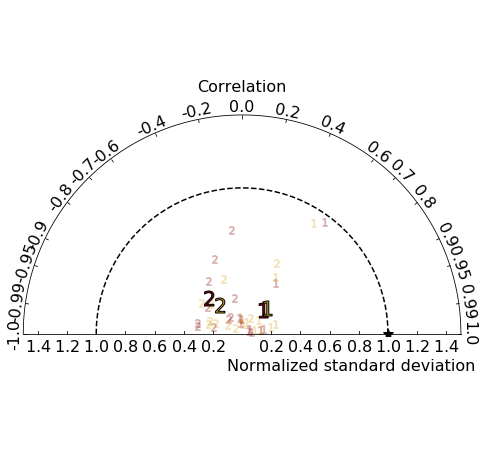

In [12]:
case_selection = None
cases_of_interest = [cases[0],cases[9]]
ncases = len(cases_of_interest)


#for dd,lid in enumerate(nyserda_obs.lidar.data):
for dd,lid in enumerate(['E06']):
    for TD_var in ['wspd']:

        
        fig_tay = plt.figure(figsize=(8,8))  
        if TD_var == 'wspd':
            srange=[0.0,1.5]
            stdevticks=np.arange(0.2,5.6,0.2)
            extend_TD = True

        dia = TaylorDiagram(1.0, fig=fig_tay, 
                            extend=extend_TD,
                            label=lid,
                            normalize=True,
                            srange=srange,
                            stdevticks=stdevticks,
                            labelsize=16,
                            extend_length=np.pi*1.0)
        for dom in doms_of_interest:
            dom_str = 'd0{}'.format(dom)
            cases_of_interest_dom = cases_of_interest.copy()
            for cc,case in enumerate(cases_of_interest_dom):
                cases_of_interest_dom[cc] += '_{}'.format(dom_str)
                print(cases_of_interest_dom)
            
            TD_stats_dict = TaylorDiagramData(obs_ds=data_ds.sel(lidar=lid,case='obs'),
                                              sim_ds=data_ds.sel(lidar=lid,case=cases_of_interest_dom),
                                              average_dim='level',
                                              members_dim='case',
                                              TD_variables=['wspd'])

            ref_std_levels = TD_stats_dict[TD_var]['ref_std']
            sim_std_levels = TD_stats_dict[TD_var]['sim_std']
            sim_cor_levels = TD_stats_dict[TD_var]['sim_cor']
            sim_bia_levels = TD_stats_dict[TD_var]['sim_bias']
            rms_levels = TD_stats_dict[TD_var]['sim_rmse']
            levels = TD_stats_dict[TD_var]['levels']


            td_stats = {}
            for cc,case in enumerate(cases_of_interest):
            #for cc,case in enumerate(cases):
                td_stats[case] = pd.DataFrame(index=levels, columns=['std_norm','R2'], dtype=float) 

                markers = [(i,j,0) for i in range(2,len(levels)+2) for j in range(1, 3)]

                for vv,lvl in enumerate(levels):
                    td_stats[case].loc[lvl,'std_norm'] = sim_std_levels[cc,vv]/ref_std_levels[cc,vv]
                    td_stats[case].loc[lvl,'R2'] = sim_cor_levels[cc,vv]

                    dia.set_ref(ref_std_levels[cc,vv])
                    if cc == 0:
                        label_str = '{}'.format(lvl)
                    else:
                        label_str = None
                    dia.add_sample(sim_std_levels[cc,vv], sim_cor_levels[cc,vv],
                                   #marker=case_dict[case]['marker'], 
                                   marker=dom_dict[dom]['marker'], 
                                   ms=8, ls='',
                                   mfc=case_dict[case]['color'], 
                                   mec=case_dict[case]['color'], # Colors
                                   #label=case_dict[case]['d03']['name'],
                                   zorder=cc,alpha=0.2)
                #plt.text(0.01,0.01+0.04*cc,case,color=case_dict[case]['d03']['color'],ha='left',va='bottom',size=16)
                td_stats[case]['angle'] = np.arccos(td_stats[case]['R2'])
                td_mean = td_stats[case].mean(axis=0)
                dia.add_sample(td_mean['std_norm'], np.cos(td_mean['angle']),
                       norm=False, # don't normalize this point
                       #marker=case_dict[case]['marker'], 
                       marker=dom_dict[dom]['marker'], 
                       ms=15, ls='',
                       mfc=case_dict[case]['color'], mec='k', # Colors
                       label=case_dict[case]['case_name'] + 'd0{0} : bias = {1:3.2f}'.format(dom,np.mean(sim_bia_levels[cc,:])),
                       zorder=cc+3,alpha=1.0)
        contours = dia.add_contours(levels=5, colors='darkblue',alpha=0.5)
        dia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
    if extend_TD:
        leg_loc = (0.01,0.85)
        leg_ncol = 3
    else:
        if case_selection == 'SST':
            leg_loc = (0.68,0.71)
        elif case_selection == 'SFC':
            leg_loc = (0.68,0.76)
        elif case_selection == 'LANDUSE':
            leg_loc = (0.68,0.81)
        else:
            leg_loc = (0.64,0.75)


        leg_ncol = 1
    fig_tay.legend(frameon=False,loc=leg_loc,fontsize=12,ncol=leg_ncol)
    #save_str = '{}/img/TD_FINO{}'.format(wrf_dir,fino)
    #if save_figs: plt.savefig('{}.png'.format(save_str))
    #plt.text(0.03,0.03,plt_str,size=20)
    plt.show()
        

In [13]:
def ensemble_statistics(ds,
                        variables=None,
                        observation_key='obs',
                        members_dim=None,
                        members=None,
                        ):

    if members_dim is None:
        raise ValueError ('Must specify dimension that defines the members (members_dim)')
    else:
        if members is None:
            members = list(ds[members_dim].data)
            members.remove(observation_key)
        
    if variables is None:
        variables = list(ds.variables)
        for coord in list(ds.coords):
            variables.remove(coord)

    new_ds = ds.copy()
    for varn in variables:
        data = ds[varn].sel({members_dim:members})
        ens_mean = data.mean(dim=members_dim)
        ens_mean_str = 'ens_mean_{}'.format(varn)
        ens_mean.name = ens_mean_str
        new_ds[ens_mean_str] = ens_mean
        
        ens_spread = (((data - ens_mean)**2).mean(dim=members_dim))**0.5
        ens_spread_str = 'ens_spread_{}'.format(varn)
        ens_spread.name = ens_spread_str
        new_ds[ens_spread_str] = ens_spread
        
        ens_error = ((ds[varn].sel({members_dim:observation_key}) - ens_mean)**2)**0.5
        ens_error_str = 'ens_error_{}'.format(varn)
        ens_error.name = ens_error_str
        new_ds[ens_error_str] = ens_error
        
    return(new_ds)

In [14]:
cases_of_interest = data_ds.case.data

ens_ds = data_ds.sel(case=cases_of_interest).copy()
delT = ens_ds.t2 - ens_ds.sst
delT.name = 'delT'
ens_ds['delT'] = delT

max_wspd = ens_ds.wspd.max(dim='level')
max_wspd.name = 'max_wspd'
ens_ds['max_wspd'] = max_wspd

hub_wspd = ens_ds.wspd.sel(level=120)
hub_wspd.name = 'hub_wspd'
ens_ds['hub_wspd'] = hub_wspd

low_shear = (ens_ds.wspd.sel(level=100) - ens_ds.wspd.sel(level=20))/80.0
low_shear.name = 'low_shear'
ens_ds['low_shear'] = low_shear
print(ens_ds)

<xarray.Dataset>
Dimensions:    (case: 9, datetime: 7, level: 10, lidar: 1)
Coordinates:
  * case       (case) object 'MERRA2_DFLT_NOSK_CHRN_MDIS_d01' ... 'obs'
  * level      (level) int64 20 40 60 80 100 120 140 160 180 200
  * datetime   (datetime) datetime64[ns] 2020-04-06T02:00:00 ... 2020-04-06T03:00:00
  * lidar      (lidar) object 'E06'
    lon        float64 ...
    lat        float64 ...
Data variables:
    wspd       (level, case, lidar, datetime) float64 9.961 9.996 ... 13.69
    wrf_level  (level, case, lidar) float64 ...
    sst        (case, lidar, datetime) float64 ...
    t2         (case, lidar, datetime) float64 ...
    delT       (case, lidar, datetime) float64 0.8085 0.8173 ... 1.007 1.03
    max_wspd   (case, lidar, datetime) float64 14.98 15.14 15.24 ... 15.41 15.04
    hub_wspd   (case, lidar, datetime) float64 14.04 14.0 13.95 ... 14.85 14.29
    low_shear  (case, lidar, datetime) float64 0.04375 0.04291 ... 0.06021


/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


In [15]:
# Not sure if there's a better way than looping... but loop to find LLJ height:
llj_height = np.zeros(np.shape(ens_ds.t2))

for tt,time in enumerate(ens_ds.datetime):
    wind_profile = ens_ds.sel(datetime=time).wspd
    for cc,case in enumerate(ens_ds.case.data):
        for ll,lid in enumerate(ens_ds.lidar.data):
            wind_profile = ens_ds.sel(datetime=time,case=case,lidar=lid).wspd
            height_profile = ens_ds.sel(datetime=time,case=case,lidar=lid).wrf_level
            if case == 'obs':
                llj_height[cc,ll,tt] = ens_ds.level[np.where(wind_profile==wind_profile.max())].data[0]                
            else:
                if np.isnan(wind_profile.max().data):
                    llj_height[cc,ll,tt] = np.nan
                else:
                    llj_height[cc,ll,tt] = height_profile[np.where(wind_profile==wind_profile.max())].data[0]

llj_height_da = xr.DataArray(
                            data=llj_height,
                            dims=['case', 'lidar', 'datetime'],
                            coords=dict(
                                case=ens_ds.case.data,
                                lidar=ens_ds.lidar.data,
                                datetime=ens_ds.datetime.data,
                            ),
                        )
ens_ds['llj_height'] = llj_height_da

/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


In [16]:
cases_of_interest = [cases[0],cases[9]]
ens_dict = {}
for dom in doms_of_interest:
    dom_str = 'd0{}'.format(dom)
    cases_of_interest_dom = cases_of_interest.copy()
    for cc,case in enumerate(cases_of_interest_dom):
        cases_of_interest_dom[cc] += '_{}'.format(dom_str)

    ens_dict[dom_str] = ensemble_statistics(ens_ds.sel(case=cases_of_interest_dom + ['obs']),members_dim='case')

In [17]:
class AnyObjectHandler(HandlerBase):
    def create_artists(self, legend, orig_handle,
                       x0, y0, width, height, fontsize, trans):
        l1 = plt.Line2D([x0,y0+width], [0.7*height,0.7*height],
                           color=orig_handle[0])
        l2 = plt.Line2D([x0,y0+width], [0.3*height,0.3*height], 
                           color=orig_handle[1])
        return [l1, l2]


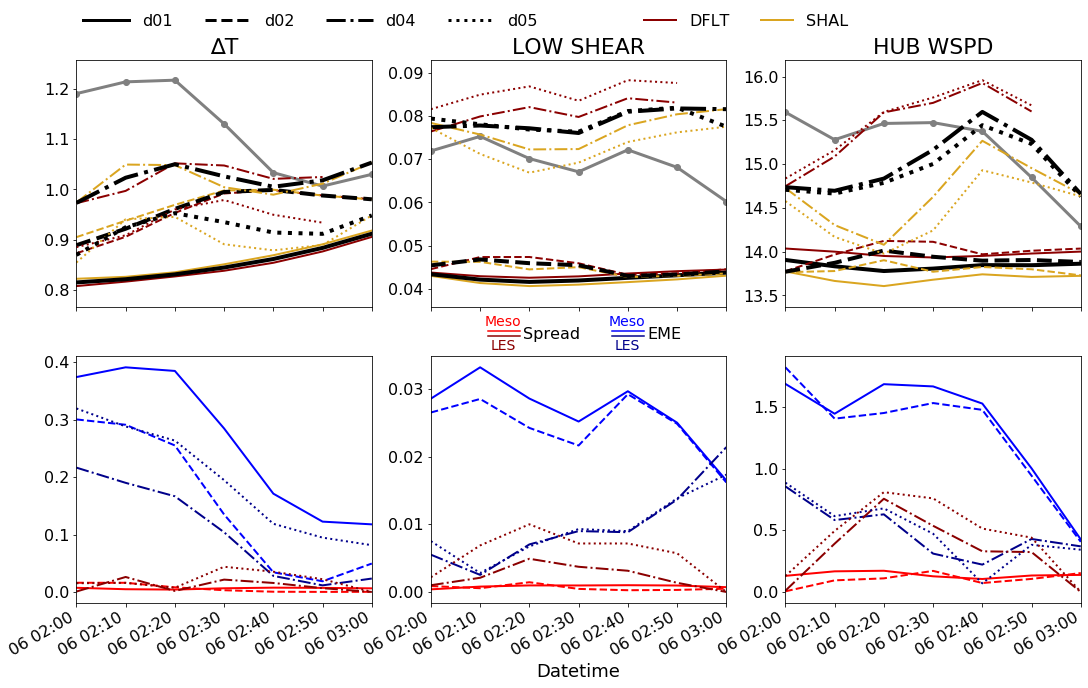

In [18]:
#variables = ['t2','sst','delT','low_shear','max_wspd','hub_wspd','llj_height']
doms_of_interest = [1,2,4,5]
variables = ['delT','low_shear','hub_wspd']

plt_start = ens_ds.datetime[0].data
plt_end = ens_ds.datetime[-1].data

fig,ax = plt.subplots(nrows=2,ncols=len(variables),figsize=(6*len(variables),10),sharex=True)

lid == 'E06'

var_min_dict = {}
var_max_dict = {}
for vv,varn in enumerate(variables):
    var_min_dict[varn] = 999
    var_max_dict[varn] = -999
    
for dd,dom in enumerate(doms_of_interest):
    mean_ls = dom_dict[dom]['ls']
    ls = '-'
        
    dom_str = 'd0{}'.format(dom)
    ens_dom_ds = ens_dict[dom_str]

    cases_of_interest_dom = cases_of_interest.copy()
    for cc,case in enumerate(cases_of_interest_dom):
        cases_of_interest_dom[cc] += '_{}'.format(dom_str)
        
    for vv,varn in enumerate(variables):
        for cc,case in enumerate(cases_of_interest_dom):
            case_str = case.replace('_{}'.format(dom_str),'')
            if (dd == 0) and (vv == 2):
                plt_lbl = case_dict[case_str]['case_name']
            else:
                plt_lbl = None
            ens_dom_ds.sel(case=case,lidar=lid)[varn].plot(ax=ax[0,vv],c=case_dict[case_str]['color'],ls=mean_ls,lw=2.0,label=plt_lbl)

        ens_dom_ds['ens_mean_{}'.format(varn)].sel(lidar=lid).plot(c='k',lw=4.0,ax=ax[0,vv],ls=mean_ls,alpha=1.0)
        if dd == 0:
            ens_dom_ds.sel(case='obs')[varn].sel(lidar=lid).plot(ax=ax[0,vv],c='grey',ls='-',marker='o',lw=3.0)
        
        if (dd == 10):
            err_str  = 'EME'
            sprd_str = 'Spread'
        else:
            err_str,sprd_str = None,None
            
        if dom >= 3:
            spr_c = 'darkred'
            err_c = 'darkblue'
        else:
            spr_c = 'r'
            err_c = 'b'

        ens_dom_ds['ens_error_{}'.format(varn)].sel(lidar=lid).plot(c=err_c,ax=ax[1,vv],label=err_str,ls=mean_ls,lw=2.0)
        ens_dom_ds['ens_spread_{}'.format(varn)].sel(lidar=lid).plot(c=spr_c,ax=ax[1,vv],label=sprd_str,ls=mean_ls,lw=2.0)
        for axi in range(0,2):
            ax[axi,vv].tick_params(labelsize=16)
            ax[axi,vv].set_ylabel('')
            ax[axi,vv].set_xlabel('')

        var_min = ens_dom_ds[varn].min()
        var_max = ens_dom_ds[varn].max()
        if var_min < var_min_dict[varn]: var_min_dict[varn] = var_min
        if var_max > var_max_dict[varn]: var_max_dict[varn] = var_max
        
        if varn == 'delT':
            var_str = '∆T'
        else:
            var_str = varn.upper().replace('_',' ')
        ax[0,vv].set_title(var_str,size=22)
        ax[1,vv].set_title('')        

        if vv == 0:
            #ax[0,vv].plot([plt_start,plt_end],[-1,-1],c='k',ls=mean_ls,label=str(dom_str),lw=2.0)
            ax[0,vv].plot([plt_start,plt_end],[-1,-1],c='k',ls=mean_ls,lw=3.0,label=str(dom_str))#+' Ens. Mean')

for vv,varn in enumerate(variables):
    var_range = var_max_dict[varn] - var_min_dict[varn]
    ax[0,vv].set_ylim(var_min_dict[varn] - var_range*0.1,var_max_dict[varn] + var_range*0.1)
ax[0,0].set_xlim(plt_start,plt_end)
ax[1,1].set_xlabel('Datetime',size=18)

ax[0,0].legend(loc=(0.0,1.1),frameon=False,ncol=4,fontsize=16,handlelength=2.9)


# Complex legend...
leg_x = 0.17
ax[1,1].legend([("r","darkred"), ("b","darkblue")], ['Spread', 'EME'],
               handler_map={tuple: AnyObjectHandler()},ncol=2,fontsize=16,
               frameon=False,loc=(leg_x,1.03),handletextpad=0.2)
ax[1,1].text(leg_x + 0.075,1.11,'Meso',c='r',ha='center',va='bottom',fontsize=14,
             transform = ax[1,1].transAxes)
ax[1,1].text(leg_x + 0.075,1.07,'LES',c='darkred',ha='center',va='top',fontsize=14,
             transform = ax[1,1].transAxes)

ax[1,1].text(leg_x + 0.495,1.11,'Meso',c='b',ha='center',va='bottom',fontsize=14,
             transform = ax[1,1].transAxes)
ax[1,1].text(leg_x + 0.495,1.07,'LES',c='darkblue',ha='center',va='top',fontsize=14,
             transform = ax[1,1].transAxes)


ax[0,2].legend(frameon=False,loc=(-0.5,1.1),ncol=4,fontsize=16)
plt.show()


/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


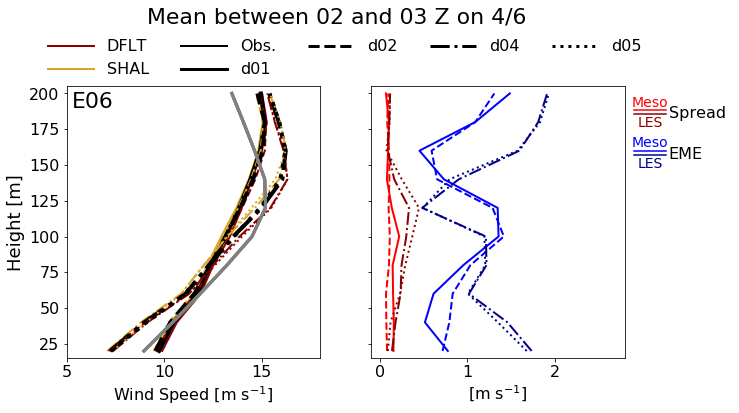

In [19]:

# Pick the time period of interest and average statistics over this period?
plt_start = pd.to_datetime(case_start)
plt_end = pd.to_datetime(case_end)


fig,ax = plt.subplots(ncols=2,figsize=(10,5),sharey=True)


varn = 'wspd'

for dd,dom in enumerate(doms_of_interest):
    
    mean_ls = dom_dict[dom]['ls']
    ls = '-'
    
    dom_str = 'd0{}'.format(dom)
    ens_dom_ds = ens_dict[dom_str]
    data_toi = ens_dom_ds.sel(datetime=slice(plt_start,plt_end)).mean(dim='datetime')

    cases_of_interest_dom = cases_of_interest.copy()
    for cc,case in enumerate(cases_of_interest_dom):
        cases_of_interest_dom[cc] += '_{}'.format(dom_str)


    for cc,case in enumerate(cases_of_interest_dom):
        case_str = case.replace('_{}'.format(dom_str),'')

        if (dd == 0):
            plt_lbl = case_dict[case_str]['case_name']
        else:
            plt_lbl = None
        data_toi.sel(case=case,lidar=lid)[varn].plot(y='level',ax=ax[0],c=case_dict[case_str]['color'],ls=mean_ls,lw=2.0,label=plt_lbl)

    data_toi['ens_mean_{}'.format(varn)].sel(lidar=lid).plot(y='level',c='k',lw=4.0,ax=ax[0],ls=mean_ls,alpha=1.0)
    data_toi.sel(case='obs')[varn].sel(lidar=lid).plot(y='level',ax=ax[0],c='grey',ls=ls,lw=3.0)

    if dd == 0:
        err_str  = 'EME'
        sprd_str = 'Spread'
    else:
        err_str = None
        sprd_str = None

    if dom >= 3:
        spr_c = 'darkred'
        err_c = 'darkblue'
    else:
        spr_c = 'r'
        err_c = 'b'
        
    data_toi['ens_error_{}'.format(varn)].sel(lidar=lid).plot(y='level',c=err_c,ax=ax[1],label=err_str,ls=mean_ls,lw=2.0)
    data_toi['ens_spread_{}'.format(varn)].sel(lidar=lid).plot(y='level',c=spr_c,ax=ax[1],label=sprd_str,ls=mean_ls,lw=2.0)
    for axi in range(0,2):
        ax[axi].tick_params(labelsize=16)
        ax[axi].set_ylabel('')
        ax[axi].set_xlabel('')
        ax[axi].set_title('')

    var_min = ens_ds[varn].min()
    var_max = ens_ds[varn].max()
    var_range = var_max - var_min
    #ax[0].set_xlim(var_min - var_range*0.1,var_max + var_range*0.1)
    var_min,var_max = 5,18
    ax[0].set_xlim(var_min,var_max)
    if varn == 'delT':
        var_str = '∆T'
    else:
        var_str = varn.upper()

    if dd == 0:
        ax[0].plot([-10,-11],[1,1],c='k',ls=ls,label='Obs.',lw=2.0)
    ax[0].plot([-10,-11],[1,1],c='k',ls=mean_ls,label=dom_str,lw=3.0)

    ax[0].set_ylabel('Height [m]',size=18)
    ax[1].set_xlim(-0.1,2.8)

ax[0].text(0.02,0.98,lid,size=22,va='top',transform=ax[0].transAxes)
ax[0].set_xlabel('Wind Speed [m s$^{-1}$]',size=16)
ax[1].set_xlabel('[m s$^{-1}$]',size=16)
ax[0].set_ylim(15,205)

ax[0].legend(loc=(-0.1,1.01),frameon=False,ncol=5,fontsize=16,handlelength=2.9)


# Complex legend...
leg_x = 1.01
leg_y = 0.7
ax[1].legend([("r","darkred"), ("b","darkblue")], ['Spread', 'EME'],
               handler_map={tuple: AnyObjectHandler()},ncol=1,fontsize=16,
               frameon=False,loc=(leg_x,leg_y),handletextpad=0.2,labelspacing=1.6)
ax[1].text(leg_x + 0.09,leg_y + 0.215,'Meso',c='r',ha='center',va='bottom',fontsize=14,
             transform = ax[1].transAxes)
ax[1].text(leg_x + 0.09,leg_y + 0.19,'LES',c='darkred',ha='center',va='top',fontsize=14,
             transform = ax[1].transAxes)

ax[1].text(leg_x + 0.09,leg_y + 0.065,'Meso',c='b',ha='center',va='bottom',fontsize=14,
             transform = ax[1].transAxes)
ax[1].text(leg_x + 0.09,leg_y + 0.04,'LES',c='darkblue',ha='center',va='top',fontsize=14,
             transform = ax[1].transAxes)

#ax[1].legend(frameon=False,loc=(0.55,0.55),fontsize=16,ncol=1)
plt.suptitle('Mean between {0:02d} and {1:02d} Z on {2}/{3}'.format(plt_start.hour,plt_end.hour,plt_start.month,plt_start.day),
             y=1.1,size=22)
plt.show()

In [20]:
def get_mean_quantities(cases,wrfout_file_list,main_directory,variables,levels=None):
    init_means = True
    get_water_depth = True

    mean_vars = {}
    for vv,varn in enumerate(variables):
        mean_vars[varn] = {}
        
    count = 0
    for tt,wrf_time in enumerate(wrfout_file_list):
        for cc,case in enumerate(cases):
            
            case_dir = '{}{}/'.format(main_directory,case)
            wrfout = xr.open_dataset('{}{}'.format(case_dir,wrf_time),decode_times=False).sel(Time=0)

            for vv,varn in enumerate(variables):
                if varn == 'wspd':
                    if levels is None:
                        varoi = (wrfout.U10**2 + wrfout.V10**2)**0.5
                    else:
                        u = wrfout.U.sel(bottom_top=levels)
                        v = wrfout.V.sel(bottom_top=levels)
                        u = 0.5*(u[:,:,1:] + u[:,:,:-1])
                        v = 0.5*(v[:,1:,:] + v[:,:-1,:])
                        u = u.rename({'west_east_stag':'west_east'})
                        v = v.rename({'south_north_stag':'south_north'})
                        varoi = (u**2 + v**2)**0.5
                else:
                    varoi = wrfout[varn]
                    if len(np.shape(varoi)) > 2:
                        if levels is not None:
                            if 'bottom_top' in varoi.dims:
                                varoi = varoi.sel(bottom_top=levels)
                            elif 'bottom_top_stag' in varoi.dims:
                                varoi = varoi.sel(bottom_top_stag=levels)
                        else:
                            raise ValueError('Dimensions are greater than 2... specify levels.')

                if init_means:
                    mean_vars[varn][case] = varoi
                else:
                    mean_vars[varn][case] += varoi
        init_means = False
        count += 1

    mean_da_dict = {}
    for cc,case in enumerate(cases):
        for vv,varn in enumerate(variables):
            mean_vars[varn][case] /= count
            da = mean_vars[varn][case]
            da = da.assign_coords({'case':case}).expand_dims({'case':1})
            da.name = varn

            mean_da_dict[varn] = da

        if cc == 0:
            mean_ds = xr.Dataset(mean_da_dict)
        else:
            mean_ds = xr.merge((mean_ds,xr.Dataset(mean_da_dict)))
        
            
    return(mean_ds)

In [21]:
avg_wrf_dict = {}
avg_time_s = pd.to_datetime('2020-04-06 02:00:00')
avg_time_e = pd.to_datetime('2020-04-06 03:00:00')

doms_of_interest = [2,5]

for cc,case in enumerate(cases_of_interest[1:]):
    for dd,dom in enumerate(doms_of_interest):
        #avg_wrf_dict[dom] = {}
        if dom <= 2:
            wrfout_path = '{}'.format(main_directory)
        else:
            wrfout_path = '{}LES/'.format(main_directory)
        wrfout_f = sorted(glob.glob('{}{}/wrfout_d0{}*'.format(wrfout_path,case,dom)))

        avg_wrfouts = []
        for ff in wrfout_f:
            wrfouttime = pd.to_datetime(' '.join(ff.split('/')[-1].split('_')[-2:]))
            if (wrfouttime >= avg_time_s) and (wrfouttime <= avg_time_e):
                avg_wrfouts.append(ff.split('/')[-1])
                 
    
        if (dom == 5) and cc == 0:
            cases_of_interest_mean = cases_of_interest[1:]
        else:
            cases_of_interest_mean = cases_of_interest
        avg_wrf_dict[dom] = get_mean_quantities(cases_of_interest_mean,avg_wrfouts,wrfout_path,['wspd','ZNT','UST'])


## Add Will's Data:

In [22]:
will_ds = xr.open_dataset('/glade/scratch/hawbecke/WRF/MMC/NYSERDA/SENSITIVITY_SUITE/LES/MERRA2_DFLT_NOSK_CHRN_MDIS/d05_output.nc').mean(dim='Time')

will_ds['wspd'] = (will_ds.U10**2 + will_ds.V10**2)**0.5
will_ds = will_ds[['wspd','ZNT','UST']]
will_ds = will_ds.assign_coords({'case':cases_of_interest[0]}).expand_dims({'case':1})

avg_wrf_dict[5] = xr.merge((avg_wrf_dict[5],will_ds))

In [23]:
d02_diff = avg_wrf_dict[2].sel(case=cases_of_interest[1]) - avg_wrf_dict[2].sel(case=cases_of_interest[0])
d05_diff = avg_wrf_dict[5].sel(case=cases_of_interest[1]) - avg_wrf_dict[5].sel(case=cases_of_interest[0])

Text(0.5, 1.0, 'd05')

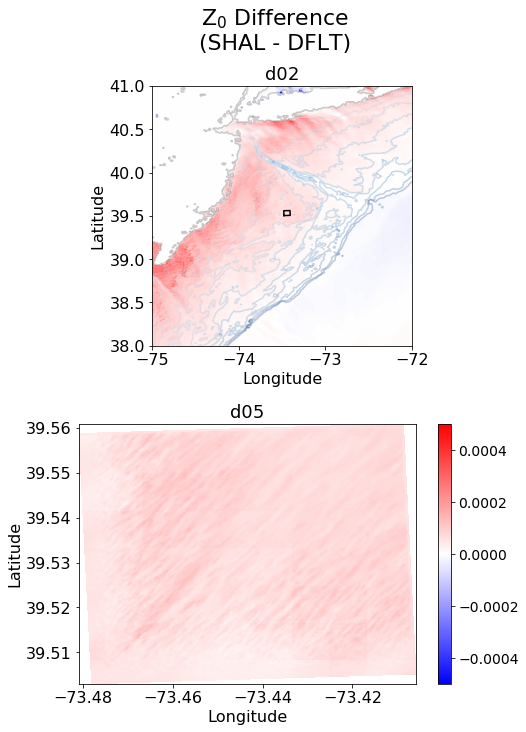

In [24]:
fig,ax = plt.subplots(nrows=2,figsize=(8,11))
plt.subplots_adjust(hspace=0.3)
pval = 0.0005
d02_in = xr.open_dataset('/glade/scratch/hawbecke/WRF/MMC/NYSERDA/SENSITIVITY_SUITE/LES/{}/wrfinput_d02'.format(cases_of_interest[1])).squeeze()
d05_in = xr.open_dataset('/glade/scratch/hawbecke/WRF/MMC/NYSERDA/SENSITIVITY_SUITE/LES/{}/wrfinput_d05'.format(cases_of_interest[1])).squeeze()

d02_lat = d02_in.XLAT
d02_lon = d02_in.XLONG
d02_landmask = d02_in.LANDMASK
d02_water_depth = d02_in.WATER_DEPTH

d05_lat = d05_in.XLAT
d05_lon = d05_in.XLONG
d05_landmask = d05_in.LANDMASK

d02_plt = ax[0].pcolormesh(d02_lon,d02_lat,d02_diff.ZNT,vmin=-pval,vmax=pval,cmap=plt.cm.bwr)
ax[0].contour(d02_lon,d02_lat,d02_landmask,levels=[0.5],colors='k',alpha=0.25)
ax[0].contour(d02_lon,d02_lat,d02_water_depth,levels=np.arange(0,101,10),cmap=plt.cm.Blues,alpha=0.25)
ax[0].set_xlim(-75,-72)
ax[0].set_ylim(38,41)
d05_plt = ax[1].pcolormesh(d05_lon,d05_lat,d05_diff.ZNT,vmin=-pval,vmax=pval,cmap=plt.cm.bwr)

#cbar = plt.colorbar(d02_plt,ax=ax[0])
cbar = plt.colorbar(d05_plt,ax=ax[1])
cbar.ax.tick_params(labelsize=14)

for axi in range(0,2):
    ax[axi].tick_params(labelsize=16)
    ax[axi].set_aspect('equal')
    ax[axi].set_xlabel('Longitude',size=16)
    ax[axi].set_ylabel('Latitude',size=16)
    
d05_outline_x = [d05_lon[0,0],d05_lon[-1,0],d05_lon[-1,-1],d05_lon[0,-1],d05_lon[0,0]]
d05_outline_y = [d05_lat[0,0],d05_lat[-1,0],d05_lat[-1,-1],d05_lat[0,-1],d05_lat[0,0]]

ax[0].plot(d05_outline_x,d05_outline_y,c='k')
plt.suptitle('Z$_0$ Difference\n(SHAL - DFLT)',size=22)#,y=1.02)
ax[0].set_title('d02',size=18)
ax[1].set_title('d05',size=18)

Text(0.5, 1.0, 'd05')

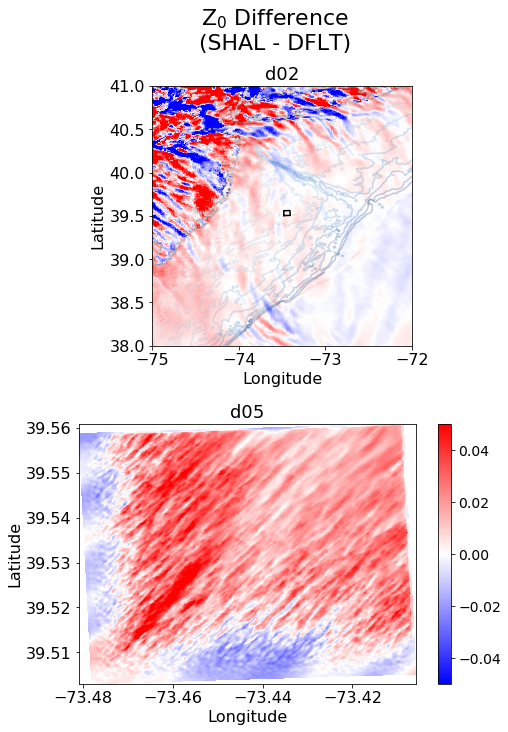

In [25]:
fig,ax = plt.subplots(nrows=2,figsize=(8,11))
plt.subplots_adjust(hspace=0.3)
pval = 0.05
d02_in = xr.open_dataset('/glade/scratch/hawbecke/WRF/MMC/NYSERDA/SENSITIVITY_SUITE/LES/{}/wrfinput_d02'.format(cases_of_interest[1])).squeeze()
d05_in = xr.open_dataset('/glade/scratch/hawbecke/WRF/MMC/NYSERDA/SENSITIVITY_SUITE/LES/{}/wrfinput_d05'.format(cases_of_interest[1])).squeeze()

d02_lat = d02_in.XLAT
d02_lon = d02_in.XLONG
d02_landmask = d02_in.LANDMASK
d02_water_depth = d02_in.WATER_DEPTH

d05_lat = d05_in.XLAT
d05_lon = d05_in.XLONG
d05_landmask = d05_in.LANDMASK

d02_plt = ax[0].pcolormesh(d02_lon,d02_lat,d02_diff.UST,vmin=-pval,vmax=pval,cmap=plt.cm.bwr)
ax[0].contour(d02_lon,d02_lat,d02_landmask,levels=[0.5],colors='k',alpha=0.25)
ax[0].contour(d02_lon,d02_lat,d02_water_depth,levels=np.arange(0,101,10),cmap=plt.cm.Blues,alpha=0.25)
ax[0].set_xlim(-75,-72)
ax[0].set_ylim(38,41)
d05_plt = ax[1].pcolormesh(d05_lon,d05_lat,d05_diff.UST,vmin=-pval,vmax=pval,cmap=plt.cm.bwr)

#cbar = plt.colorbar(d02_plt,ax=ax[0])
cbar = plt.colorbar(d05_plt,ax=ax[1])
cbar.ax.tick_params(labelsize=14)

for axi in range(0,2):
    ax[axi].tick_params(labelsize=16)
    ax[axi].set_aspect('equal')
    ax[axi].set_xlabel('Longitude',size=16)
    ax[axi].set_ylabel('Latitude',size=16)
    
d05_outline_x = [d05_lon[0,0],d05_lon[-1,0],d05_lon[-1,-1],d05_lon[0,-1],d05_lon[0,0]]
d05_outline_y = [d05_lat[0,0],d05_lat[-1,0],d05_lat[-1,-1],d05_lat[0,-1],d05_lat[0,0]]

ax[0].plot(d05_outline_x,d05_outline_y,c='k')
plt.suptitle('Z$_0$ Difference\n(SHAL - DFLT)',size=22)#,y=1.02)
ax[0].set_title('d02',size=18)
ax[1].set_title('d05',size=18)